In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import warnings
warnings.filterwarnings('ignore')
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

from tqdm import tqdm
import joblib

import random
random.seed(2020)

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import MiniBatchKMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import log_loss
import lightgbm as lgb
from datetime import datetime, timedelta

In [6]:
train = pd.read_pickle('train_data.pickle.zip')
test = pd.read_pickle('test_data.pickle.zip')
train_label = train['label']

In [4]:
var_list = list(pd.read_csv('var_list.csv')['var'])

In [5]:
var_list = list(reversed(sorted(list(set(var_list) - set(train.columns[train.isna().any()].tolist() + test.columns[test.isna().any()].tolist())))))

train = train.loc[(train['time'] >= 10),var_list].reset_index(drop=True)
test = test.loc[(test['time'] >= 10),list(set(var_list) - set(['label']))].reset_index(drop=True)

In [7]:
all = pd.concat([train,test],axis=0)
all_value_cnt = all.nunique()

In [8]:
cat_var = list(all_value_cnt[(all_value_cnt < 11) & (all_value_cnt > 2)].index)
bin_var = list(all_value_cnt[all_value_cnt == 2].index)
num_var = list(set(var_list) - set(cat_var) - set(bin_var) - set(['label','id','time']))
etc_var = ['label','id','time']

In [9]:
import_var = ['V3616','V0081','V3324','V3615','V2855','V2859','V1821','V1818','V3098',
 'V3461','V4505','V1820','V2861','V2860','V1819','V3432','V2586','V2854',
 'V4743','V4824','V3103','V2853','V4495','V2076','V4525']

In [10]:
cat_lbl = pd.DataFrame()
for a in (bin_var + cat_var):
    cat_lbl[a] = pd.factorize(all[a])[0]

dup_cols = {}
for i, c1 in enumerate(tqdm(cat_lbl.columns)):
    for c2 in cat_lbl.columns[i+1:]:
        if c2 not in dup_cols and np.all(cat_lbl[c1] == cat_lbl[c2]):
            dup_cols[c2] = c1

cat_lbl.drop(dup_cols.keys(), axis = 1, inplace = True)
cat_lbl.shape

100%|████████████████████████████████████████████████████████████████████████████████| 335/335 [00:31<00:00, 10.50it/s]


(77400, 261)

In [11]:
num = cat_lbl.nunique()
cat_var = list(num[num > 2].index)
bin_var = list(num[num == 2].index)

var_type_list = pd.DataFrame({'var' : etc_var + cat_var + bin_var + num_var,
              'type' : np.concatenate([np.repeat(['etc'],3),
                                       np.repeat(['cat'],len(cat_var)),
                                       np.repeat(['bin'],len(bin_var)),
                                       np.repeat(['num'],len(num_var))])})

grp_var = list(var_type_list[var_type_list['type'] == 'cat']['var']);grp_var[:5]

all = all[etc_var + num_var + cat_var + bin_var]

In [12]:
concat_var = [['V0050','V0051'],['V0469','V0471','V0472'],['V0529','V0530','V0532'],['V0731','V0733','V0735'],['V4502','V4504'],['V4526','V4527']]

for a in tqdm(concat_var):
    
    colnm = '_'.join(a + ['concat'])
    temp = pd.Series(np.repeat('',len(all)))
    
    for col in a:
        temp2 = all[col].astype(str)
        temp = temp.str.cat(temp2)
        
        all[colnm] = pd.factorize(temp)[0]

100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.93it/s]


In [13]:
for col in tqdm(cat_var + [a for a in all.columns if 'concat' in a]):
    temp = all.groupby(col)['id'].count().to_dict()
    all[col+'_freq'] = all[col].map(temp)
    del temp

100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [00:00<00:00, 51.84it/s]


In [14]:
all.shape

(77400, 2521)

In [15]:
for i,col1 in enumerate(import_var[:5]):
    for i2 in range(i+1,5):
        all[col1+'*'+import_var[:5][i2]] = all[col1] * all[import_var[:5][i2]]
        all[col1+'/'+import_var[:5][i2]] = all[col1] / all[import_var[:5][i2]]
        all[col1+'+'+import_var[:5][i2]] = all[col1] + all[import_var[:5][i2]]
        all[col1+'-'+import_var[:5][i2]] = all[col1] - all[import_var[:5][i2]]

In [16]:
train = all[~all['label'].isnull()].reset_index(drop=True).drop(columns = ['time'])
test = all[all['label'].isnull()].reset_index(drop=True).drop(columns = ['time','label'])

del all

In [17]:
%%time

train = train.groupby('id').rolling(window = 5).mean().drop(columns = ['id']).reset_index().drop(columns = ['level_1']).dropna().reset_index(drop=True)
train_label = train['label']
train_id = train['id']

test = test.groupby('id').rolling(window = 5).mean().drop(columns = ['id']).reset_index().drop(columns = ['level_1']).dropna().reset_index(drop=True)
test_id = test['id']

var_model = list(set(train.columns) & set(test.columns) - set(['id']))

Wall time: 55.2 s


In [18]:
lbl = pd.DataFrame({'label' : train['label']})

In [19]:
lbl = pd.DataFrame({'label' : train['label']})
lbl['freq'] = lbl['label'].map(lbl['label'].value_counts().to_dict())

Fold : 0
training shape : (28566, 2558)
validation shape : (9522, 2558)
test shape : (33120, 2558)
Training until validation scores don't improve for 100 rounds.
[100]	training's multi_logloss: 0.0255355	valid_1's multi_logloss: 0.200952
[200]	training's multi_logloss: 0.00304524	valid_1's multi_logloss: 0.12226
[300]	training's multi_logloss: 0.00134383	valid_1's multi_logloss: 0.10393
[400]	training's multi_logloss: 0.00084524	valid_1's multi_logloss: 0.0951202
[500]	training's multi_logloss: 0.000613867	valid_1's multi_logloss: 0.0895877
[600]	training's multi_logloss: 0.000481279	valid_1's multi_logloss: 0.0856029
[700]	training's multi_logloss: 0.000395744	valid_1's multi_logloss: 0.0825676
[800]	training's multi_logloss: 0.000336061	valid_1's multi_logloss: 0.0801639
[900]	training's multi_logloss: 0.000292051	valid_1's multi_logloss: 0.0781662
[1000]	training's multi_logloss: 0.000258327	valid_1's multi_logloss: 0.0764802
Did not meet early stopping. Best iteration is:
[1000]	tr

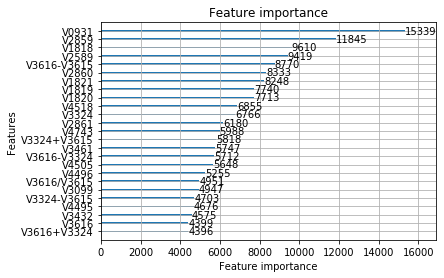

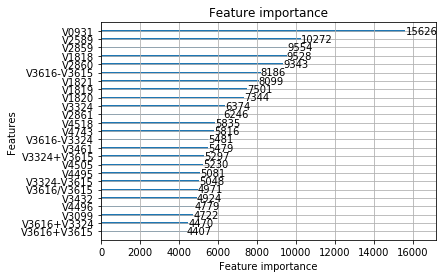

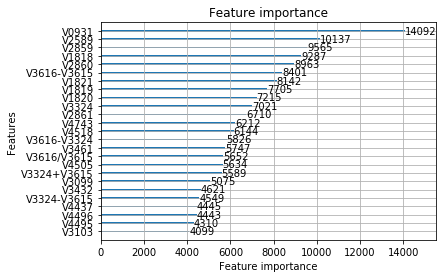

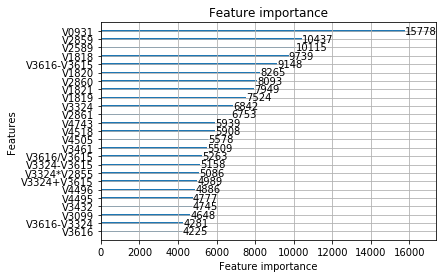

In [21]:
%%time
# lbl_dup = train[['id','label']].drop_duplicates().reset_index(drop=True)
# lbl_dup['label_freq'] = lbl_dup['label'].map(lbl_dup['label'].value_counts().to_dict())

from sklearn.model_selection import StratifiedKFold
stk = StratifiedKFold(n_splits=4,random_state = 1995,shuffle=True)

prediction = []

for fold_, (tr_id, vl_id) in enumerate(stk.split(lbl,lbl['freq'])):
    print('Fold :',fold_)
    
    x_tr = train.iloc[tr_id,:]
    x_vl = train.iloc[vl_id,:]
    
    y_tr = x_tr['label']
    y_vl = x_vl['label']
    
    print('training shape :', x_tr[var_model].shape)
    print('validation shape :', x_vl[var_model].shape)
    print('test shape :', test[var_model].shape)

    lgb_tr = lgb.Dataset(x_tr[var_model], label=y_tr)
    lgb_vl = lgb.Dataset(x_vl[var_model], label=y_vl)

    watchlist_1 = [lgb_tr, lgb_vl]
    watchlist_2 = [lgb_vl, lgb_tr]

    params = {
        "objective": "multiclass",
        "boosting": "gbdt",
        "num_leaves": 40,
        "learning_rate": 0.05,
        "feature_fraction": 0.85,
        "reg_lambda": 2,
        "metric": "multiclass",
        "num_class" : 198
    }

    lgb_model = lgb.train(params, train_set=lgb_tr, num_boost_round=1000, valid_sets=watchlist_1, verbose_eval=100, early_stopping_rounds=100)
    
    print('save model')
    joblib.dump(lgb_model, 'lgb_'+str(fold_)+'.pkl')

    print('predicting')
    prediction += [pd.DataFrame(lgb_model.predict(test[var_model]))]
    
    lgb.plot_importance(lgb_model,max_num_features = 25)

In [22]:
temp = prediction[0]
pred1 = pd.concat([pd.DataFrame(test_id),temp],axis=1).groupby('id').mean().reset_index()

temp = prediction[1]
pred2 = pd.concat([pd.DataFrame(test_id),temp],axis=1).groupby('id').mean().reset_index()

temp = prediction[2]
pred3 = pd.concat([pd.DataFrame(test_id),temp],axis=1).groupby('id').mean().reset_index()

temp = prediction[3]
pred4 = pd.concat([pd.DataFrame(test_id),temp],axis=1).groupby('id').mean().reset_index()


sub = (pred1 + pred2 + pred3 + pred4)/4

sub['id'] = sub['id'].astype('int')

In [29]:
sub.to_csv('stratified.csv',index=False)

In [23]:
time_now = datetime.now() + timedelta(hours = 9)
submission_name = str(time_now)[:16] + '_submission.csv'
sub.to_csv(submission_name,index=False)

In [25]:
print(pred1.shape)
print(pred2.shape)
print(pred3.shape)

(720, 199)
(720, 199)
(720, 199)
